In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

# STEP 1 DATA

## gebco data for bathymetry

In [1]:

# Path to your GEBCO NetCDF file
gebco_file = '/Users/mnky9800n/repos/agartha/agartha/data/dap.ceda.ac.uk/bodc/gebco/global/gebco_2025/ice_surface_elevation/netcdf/GEBCO_2025.nc'

# Open the dataset
ds = xr.open_dataset(gebco_file)

In [42]:

# Print the dataset structure to inspect available variables
ds

<xarray.Dataset> Size: 4MB
Dimensions:    (lat: 1200, lon: 1680)
Coordinates:
  * lon        (lon) float64 13kB -161.0 -161.0 -161.0 ... -154.0 -154.0 -154.0
  * lat        (lat) float64 10kB 18.0 18.01 18.01 18.01 ... 22.99 22.99 23.0
Data variables:
    crs        |S1 1B ...
    elevation  (lat, lon) int16 4MB -5498 -5493 -5489 ... -4577 -4573 -4538
Attributes: (12/36)
    title:                           The GEBCO_2025 Grid - a continuous terra...
    summary:                         The GEBCO_2025 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/37c52e96-24ea-67ce-e063-708...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/37c52e96-24ea-67ce-e063-708...
    references:                      DOI: 10.5285/37c52e96-24ea-67ce-e063-708...
    node_offset:                     1.0

In [3]:
# Define bounding box for Hawaii (approximate values)
min_lon, max_lon = -161, -154
min_lat, max_lat = 18, 23

# Select the region around Hawaii
ds = ds.sel(lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat))

In [4]:
# Common variable names in GEBCO datasets:
# - 'elevation', 'lon', 'lat' or sometimes 'z', 'longitude', 'latitude'
elevation = ds['elevation']  # or ds['z']
lon = ds['lon']              # or ds['longitude']
lat = ds['lat']              # or ds['latitude']

# For quick access, convert to numpy arrays
elev_array = elevation.values
lon_array = lon.values
lat_array = lat.values


In [5]:
import torch

In [6]:
# TODO : you should remove this, dataexplorer should only be used for showing the data sets

class GebcoDataset(torch.utils.data.Dataset):
    def __init__(self, netcdf_path):
        self.ds = xr.open_dataset(netcdf_path)
        self.elev_da = self.ds['elevation']
        self.lats = self.ds['lat'].values
        self.lons = self.ds['lon'].values
        
        # Print coordinate info for debugging
        print(f"Latitude range: {self.lats.min():.2f} to {self.lats.max():.2f}")
        print(f"Longitude range: {self.lons.min():.2f} to {self.lons.max():.2f}")
        print(f"Lat ascending: {self.lats[0] < self.lats[-1]}")
        
    def __len__(self):
        return len(self.lats) * len(self.lons)

    def __getitem__(self, bbox):
        lat_min, lat_max, lon_min, lon_max = bbox
        print(f"Requested bbox: lat({lat_min}, {lat_max}), lon({lon_min}, {lon_max})")
        
        # Handle longitude conversion if dataset uses 0-360
        if self.lons.min() >= 0 and lon_min < 0:
            lon_min = lon_min + 360
            lon_max = lon_max + 360
            print(f"Converted to 0-360: lon({lon_min}, {lon_max})")
        
        # Determine latitude slice order (depends on whether coords are ascending/descending)
        if self.lats[0] > self.lats[-1]:  # Descending latitudes
            lat_slice = slice(lat_max, lat_min)
        else:  # Ascending latitudes
            lat_slice = slice(lat_min, lat_max)
            
        lon_slice = slice(lon_min, lon_max)
        
        # Select subset
        elev_subset_da = self.elev_da.sel(lat=lat_slice, lon=lon_slice)
        
        print(f"Selected {len(elev_subset_da.lat)} lats, {len(elev_subset_da.lon)} lons")
        print(f"Actual lat range: {elev_subset_da.lat.values}")
        print(f"Actual lon range: {elev_subset_da.lon.values}")
        
        # Convert to tensors
        elev_subset = torch.from_numpy(elev_subset_da.values.astype(np.float32))
        lat_subset = torch.from_numpy(elev_subset_da['lat'].values.astype(np.float32))
        lon_subset = torch.from_numpy(elev_subset_da['lon'].values.astype(np.float32))
        
        return elev_subset, lat_subset, lon_subset

In [7]:
gb = GebcoDataset(netcdf_path=gebco_file)

Latitude range: -90.00 to 90.00
Longitude range: -180.00 to 180.00
Lat ascending: True


In [8]:
# Define bounding box for Hawaii (approximate values)
min_lon, max_lon = -161, -154
min_lat, max_lat = 18, 23

# Select the region around Hawaii
elev_array, lat_array, lon_array = gb[(min_lat, max_lat, min_lon, max_lon)]

Requested bbox: lat(18, 23), lon(-161, -154)
Selected 1200 lats, 1680 lons
Actual lat range: [18.00208333 18.00625    18.01041667 ... 22.98958333 22.99375
 22.99791667]
Actual lon range: [-160.99791667 -160.99375    -160.98958333 ... -154.01041667 -154.00625
 -154.00208333]


In [9]:
lat_array

tensor([18.0021, 18.0063, 18.0104,  ..., 22.9896, 22.9937, 22.9979])

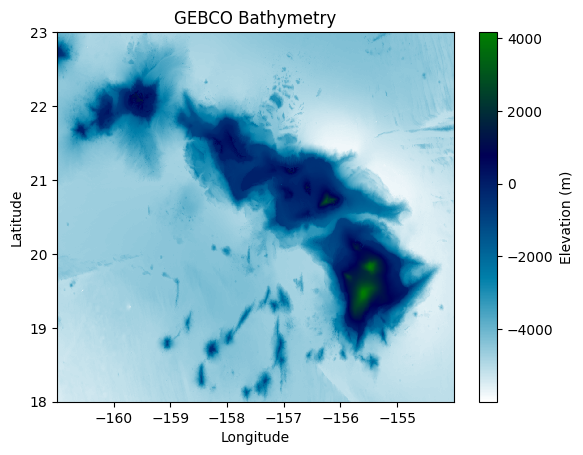

In [10]:
plt.pcolormesh(lon_array, lat_array, elev_array, cmap='ocean_r')
# plt.pcolormesh(gb.lons, gb.lats, gb.elev, cmap='ocean_r')
plt.colorbar(label='Elevation (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GEBCO Bathymetry')
plt.show()

## ECM1 data

In [22]:
ecm1_path = 'data/ecm1/ECM1.txt'
ecm1_df = pd.read_csv(ecm1_path, sep='\s+')

In [24]:
ecm1_gf = gpd.GeoDataFrame(ecm1_df, geometry=gpd.points_from_xy(x=ecm1_df.Lon, y=ecm1_df.Lat), crs='EPSG:4326')

In [50]:
class ecm1Dataset(torch.utils.data.Dataset):
    def __init__(self, file_loc):
        self.df = pd.read_csv(file_loc, sep='\s+')
        self.gdf = gpd.GeoDataFrame(ecm1_df,  geometry=gpd.points_from_xy(x=ecm1_df.Lon, y=ecm1_df.Lat), crs='EPSG:4326')
        self.xr = self.gdf.to_xarray()
        self.lons = self.xr['Lon'].values
        self.lats = self.xr['Lat'].values

        # Print coordinate info for debugging
        print(f"Latitude range: {self.lats.min():.2f} to {self.lats.max():.2f}")
        print(f"Longitude range: {self.lons.min():.2f} to {self.lons.max():.2f}")
        print(f"Lat ascending: {self.lats[0] < self.lats[-1]}")

        # TODO : rename these into something useful
        self.Hcc = self.xr['Hcc'].values
        self.Sed = self.xr['Sed'].values
        self.Hc = self.xr['Hc'].values
        self.Type = self.xr['Type'].values
        self.DLy1 = self.xr['DLy1'].values
        self.DLy2 = self.xr['DLy2'].values
        self.DLy3 = self.xr['DLy3'].values
        self.TLy1 = self.xr['TLy1'].values
        self.TLy2 = self.xr['TLy2'].values
        self.TLy3 = self.xr['TLy3'].values
        self.VP1 = self.xr['VP1'].values
        self.VP2 = self.xr['VP2'].values
        self.VP3 = self.xr['VP3'].values
        self.VS1 = self.xr['VS1'].values
        self.VS2 = self.xr['VS2'].values
        self.VS3 = self.xr['VS3'].values
        self.VPN = self.xr['VPN'].values
        self.VSN = self.xr['VSN'].values
        self.RHO1 = self.xr['RHO1'].values
        self.RHO2 = self.xr['RHO2'].values 
        self.RHO3 = self.xr['RHO3'].values
        self.RHON = self.xr['RHON'].values

    def __len__(self):
        return len(self.lons) * len(self.lats)

    def __getitem__(self, lat, lon, value):
        idx = np.where((self.lons==lon) & (self.lats==lat))
        if key in self.__dict__:
            return self.__dict__[key][idx]
        else:
            raise ValueError(f'{key} is not a variable name in this data set')

ec = ecm1Dataset(ecm1_path)
ec[lat==44.5, lon==13.5, value=='VP1']

Latitude range: -89.50 to 89.50
Longitude range: -179.50 to 179.50
Lat ascending: False


NameError: name 'value' is not defined

In [43]:
class myclass:
    def __init__(self):
        self.x = 1
        self.y = 2

    def __getitem__(self, key):
        if key in self.__dict__:
            return self.__dict__[key]

mc = myclass()
mc['x']

1

In [31]:
ecm1_gf.columns

Index(['Numb', 'Lon', 'Lat', 'Hcc', 'Sed', 'Hc', 'Type', 'DLy1', 'DLy2',
       'DLy3', 'TLy1', 'TLy2', 'TLy3', 'VP1', 'VP2', 'VP3', 'VS1', 'VS2',
       'VS3', 'VPN', 'VSN', 'RHO1', 'RHO2', 'RHO3', 'RHON', 'geometry'],
      dtype='object')

<Axes: >

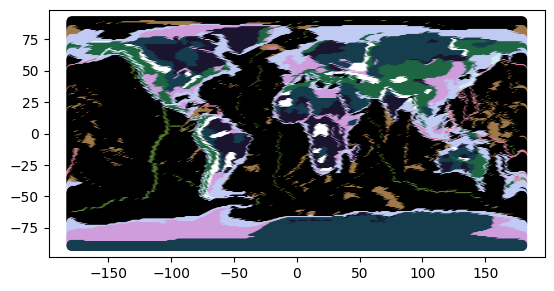

In [30]:
ecm1_gf.plot('Type', cmap='cubehelix_r')

In [41]:
ecm1_df[(ecm1_df.Lon==100.5) & (ecm1_df.Lat==88.5)]

,Numb,Lon,Lat,Hcc,Sed,Hc,Type,DLy1,DLy2,DLy3,...,VP3,VS1,VS2,VS3,VPN,VSN,RHO1,RHO2,RHO3,RHON
640,641,100.5,88.5,8.1758,1.7795,9.9553,SOCE,4.4775,7.1755,9.9553,...,6.739467,3.217479,3.441446,3.807608,8.028349,4.467863,2.654495,2.736552,2.895387,3.301104


In [32]:
ecm1_gf.to_xarray()

<xarray.Dataset> Size: 14MB
Dimensions:   (index: 64800)
Coordinates:
  * index     (index) int64 518kB 0 1 2 3 4 5 ... 64795 64796 64797 64798 64799
Data variables: (12/26)
    Numb      (index) int64 518kB 1 2 3 4 5 6 ... 64796 64797 64798 64799 64800
    Lon       (index) float64 518kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    Lat       (index) float64 518kB 89.5 89.5 89.5 89.5 ... -89.5 -89.5 -89.5
    Hcc       (index) float64 518kB 6.446 6.351 6.251 6.152 ... 39.0 39.0 39.0
    Sed       (index) float64 518kB 2.33 2.334 2.34 2.346 ... 0.0 0.0 0.0 0.0
    Hc        (index) float64 518kB 8.776 8.685 8.591 8.498 ... 39.0 39.0 39.0
    ...        ...
    VSN       (index) float64 518kB 4.468 4.468 4.468 ... 4.538 4.538 4.538
    RHO1      (index) float64 518kB 2.654 2.654 2.654 ... 2.753 2.753 2.753
    RHO2      (index) float64 518kB 2.737 2.737 2.737 ... 2.842 2.842 2.842
    RHO3      (index) float64 518kB 2.895 2.895 2.895 ... 2.942 2.942 2.942
    RHON      (index) float64 518kB 3.301 3.301 3.301 ... 3.337 3.337 3.337
    geometry  (index) geometry 518kB POINT (-179.5 89.5) ... POINT (179.5 -89.5)

# STEP 2 Data

## SeisCRUST Data Exploration

Now let's load and visualize the SeisCRUST bulk crustal properties data.

In [11]:
import pandas as pd

# Load the SeisCRUST data
seiscrust_file = '/Users/mnky9800n/repos/agartha/agartha/data/SeisCrust/BULK_CRUSTAL_PROPERTIES/av_vp_vs_rho_all_stephenson_T_DEPENDENT.dat'

# Read the data file (space-separated with NaN values)
seiscrust_df = pd.read_csv(seiscrust_file, sep='\s+', na_values='nan')

seiscrust_df

,station,lon,lat,moho,av_vp,av_vs,av_rho
0,T03_LMG_Vp,-77.0047,20.0673,19.0,6.183716,NaN,2.901904
1,T03_CCC_Vp,-77.4172,21.1937,31.0,6.159473,NaN,2.831624
2,T03_MOA_Vp,-74.9568,20.6583,29.0,6.060940,NaN,2.758240
3,T03_SOR_Vp,-83.0180,22.7830,27.0,6.134902,NaN,2.911869
4,T03_RCC_Vp,-75.6965,19.9953,18.0,5.696322,NaN,2.771630
...,...,...,...,...,...,...,...
30787,NaN,178.4540,-18.1150,28.5,NaN,NaN,2.822748
30788,NaN,178.0530,-17.7450,28.5,NaN,NaN,2.822748
30789,NaN,179.4500,-16.3020,26.0,NaN,NaN,2.810601
30790,NaN,-178.8140,-18.2330,23.5,NaN,NaN,2.798525


In [16]:
sc_gf = gpd.GeoDataFrame(seiscrust_df, geometry=gpd.points_from_xy(x=seiscrust_df.lon, y=seiscrust_df.lat), crs='EPSG:4326')

<Axes: >

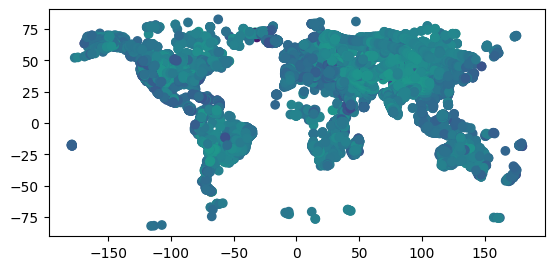

In [17]:
sc_gf.plot('av_rho')